In [1]:
import sys
import os

# Get the absolute path to the project root directory (parent of both notebooks and src)
project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
sys.path.append(project_root)

# Then import the module directly
from src.data_preprocessing import create_augmented_dataset

# Define paths
src_dataset_root = '../Dataset/'
dst_dataset_root = '../Dataset_unaugmented/'

# Create augmented dataset (adds 3 variations per original image)
create_augmented_dataset(src_dataset_root, dst_dataset_root, augmentation_per_image=3)

Splitting TrainVal set: 2944 training images, 736 validation images
Processing training set...
Processed 10/2944 training images
Processed 20/2944 training images
Processed 30/2944 training images
Processed 40/2944 training images
Processed 50/2944 training images
Processed 60/2944 training images
Processed 70/2944 training images
Processed 80/2944 training images
Processed 90/2944 training images
Processed 100/2944 training images
Processed 110/2944 training images
Processed 120/2944 training images
Processed 130/2944 training images
Processed 140/2944 training images
Processed 150/2944 training images
Processed 160/2944 training images
Processed 170/2944 training images
Processed 180/2944 training images
Processed 190/2944 training images
Processed 200/2944 training images
Processed 210/2944 training images
Processed 220/2944 training images
Processed 230/2944 training images
Processed 240/2944 training images
Processed 250/2944 training images
Processed 260/2944 training images
Proc

# Examine Dataset Structure

In [2]:
# Check the new dataset structure and count files
train_dir = os.path.join(dst_dataset_root, 'train', 'color')
val_dir = os.path.join(dst_dataset_root, 'val', 'color')
test_dir = os.path.join(dst_dataset_root, 'test', 'color')

if os.path.exists(train_dir):
    train_files = os.listdir(train_dir)
    train_orig = [f for f in train_files if '_aug' not in f]
    train_aug = [f for f in train_files if '_aug' in f]
    print(f"Train set: {len(train_files)} total files")
    print(f"  - {len(train_orig)} original images")
    print(f"  - {len(train_aug)} augmented images")
    print(f"  - {len(train_aug)/len(train_orig):.1f}x augmentation ratio")
else:
    print(f"Train directory not found at {train_dir}")

if os.path.exists(val_dir):
    val_files = os.listdir(val_dir)
    print(f"Validation set: {len(val_files)} total files")
    aug_in_val = [f for f in val_files if '_aug' in f]
    if aug_in_val:
        print(f"  WARNING: Found {len(aug_in_val)} augmented files in validation set!")
else:
    print(f"Validation directory not found at {val_dir}")

if os.path.exists(test_dir):
    test_files = os.listdir(test_dir)
    print(f"Test set: {len(test_files)} total files")
    aug_in_test = [f for f in test_files if '_aug' in f]
    if aug_in_test:
        print(f"  WARNING: Found {len(aug_in_test)} augmented files in test set!")
else:
    print(f"Test directory not found at {test_dir}")

Train set: 11776 total files
  - 2944 original images
  - 8832 augmented images
  - 3.0x augmentation ratio
Validation set: 736 total files
Test set: 3710 total files


# Create Data Loaders

In [3]:
from src.data_preprocessing import get_data_loaders

# Create data loaders from the augmented dataset
train_loader, val_loader, test_loader = get_data_loaders(dst_dataset_root, batch_size=16)

print("\nVerifying data shapes:")
# Get a sample batch from each loader
try:
    train_batch = next(iter(train_loader))
    print(f"Train batch: {train_batch[0].shape} (images), {train_batch[1].shape} (masks)")
except Exception as e:
    print(f"Error loading train batch: {e}")

try:
    val_batch = next(iter(val_loader))
    print(f"Val batch: {val_batch[0].shape} (images), {val_batch[1].shape} (masks)")
except Exception as e:
    print(f"Error loading val batch: {e}")

try:
    test_batch = next(iter(test_loader))
    print(f"Test batch: {test_batch[0].shape} (images), {test_batch[1].shape} (masks)")
except Exception as e:
    print(f"Error loading test batch: {e}")

Training set size: 11776
Validation set size: 736
Test set size: 3710

Verifying data shapes:
Train batch: torch.Size([16, 3, 224, 224]) (images), torch.Size([16, 224, 224]) (masks)
Val batch: torch.Size([16, 3, 224, 224]) (images), torch.Size([16, 224, 224]) (masks)
Test batch: torch.Size([16, 3, 224, 224]) (images), torch.Size([16, 224, 224]) (masks)


# Confirm that the data loaders are working correctly

Sample from training set:


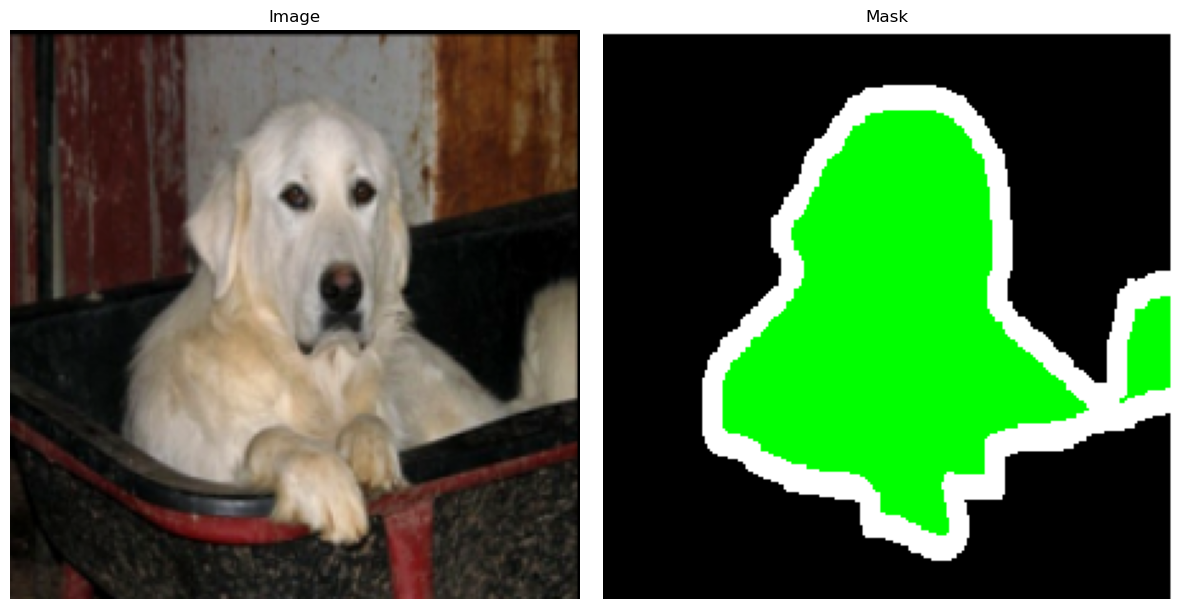

Sample from validation set:


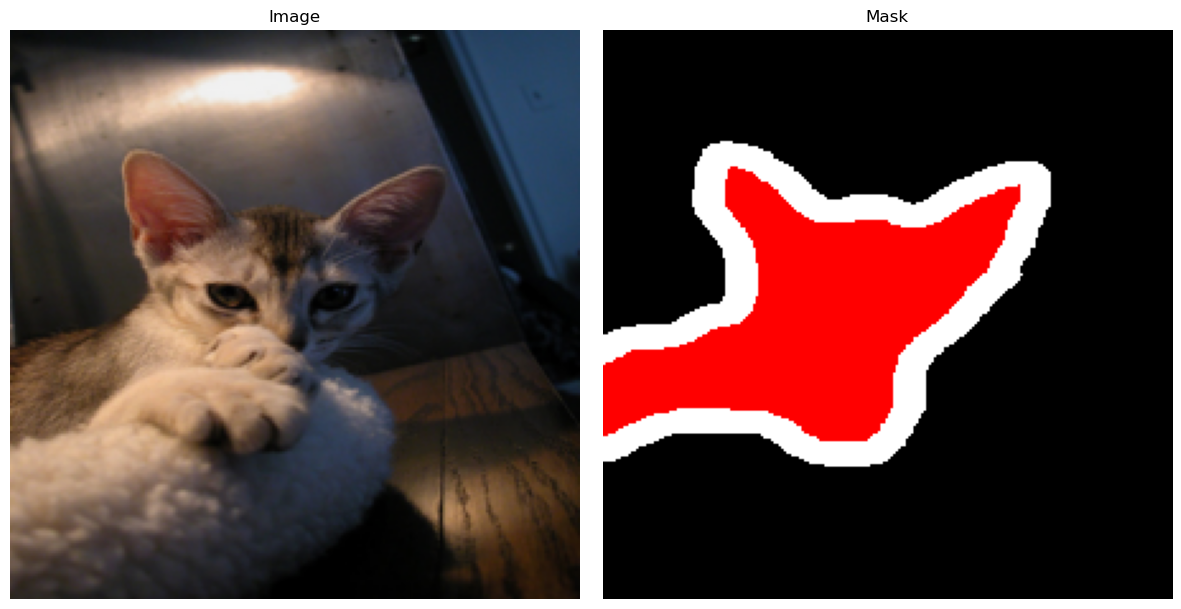

Sample from test set:


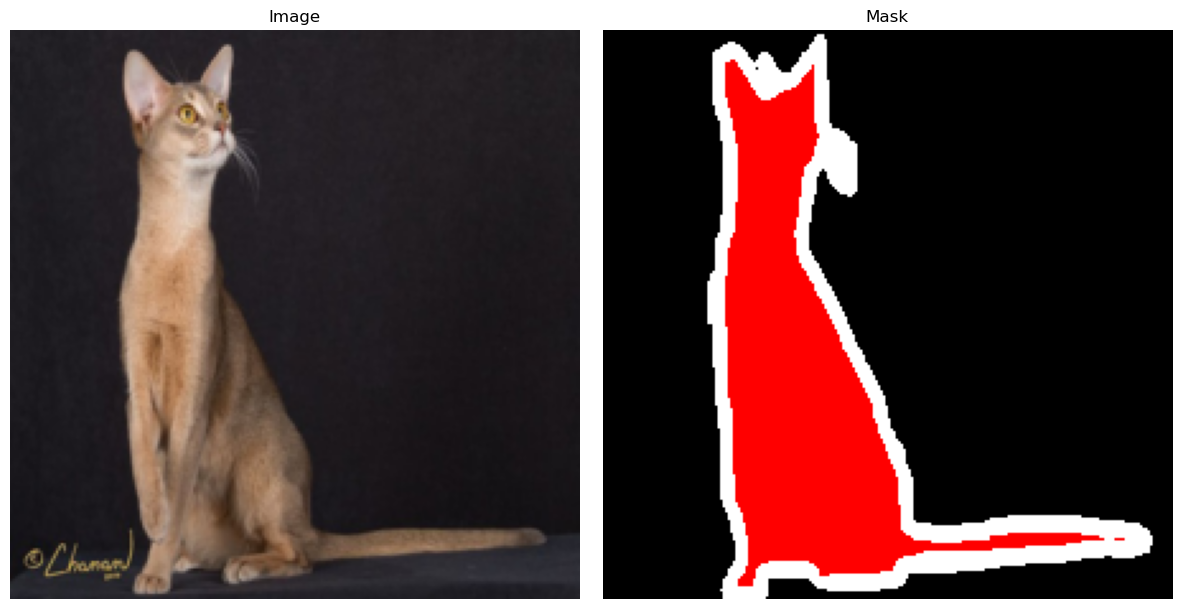

In [4]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.functional as TF
import numpy as np

def visualize_sample(image, mask):
    """Visualize an image and its segmentation mask"""
    if isinstance(image, torch.Tensor):
        image_np = image.permute(1, 2, 0).numpy()
    else:
        image_np = np.array(image)
    
    if isinstance(mask, torch.Tensor):
        mask_np = mask.numpy()
    else:
        mask_np = np.array(mask)
    
    # Create a colormap for the mask
    mask_colors = np.array([
        [0, 0, 0],          # Background (black)
        [1, 0, 0],          # Cat (red)
        [0, 1, 0],          # Dog (green)
        [1, 1, 1],          # Ignore (white)
    ])
    
    # Create colored mask
    colored_mask = np.zeros((mask_np.shape[0], mask_np.shape[1], 3))
    for i in range(3):  # Background, Cat, Dog
        colored_mask[mask_np == i] = mask_colors[i]
    # Handle ignore index
    colored_mask[mask_np == 255] = mask_colors[3]
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image_np)
    axes[0].set_title("Image")
    axes[0].axis('off')
    
    axes[1].imshow(colored_mask)
    axes[1].set_title("Mask")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize samples from each loader
try:
    train_imgs, train_masks = next(iter(train_loader))
    print("Sample from training set:")
    visualize_sample(train_imgs[0], train_masks[0])
except Exception as e:
    print(f"Error displaying train sample: {e}")

try:
    val_imgs, val_masks = next(iter(val_loader))
    print("Sample from validation set:")
    visualize_sample(val_imgs[0], val_masks[0])
except Exception as e:
    print(f"Error displaying validation sample: {e}")

try:
    test_imgs, test_masks = next(iter(test_loader))
    print("Sample from test set:")
    visualize_sample(test_imgs[0], test_masks[0])
except Exception as e:
    print(f"Error displaying test sample: {e}")

# Summary

The augmented dataset has been successfully created with:
- Proper train/val/test split (80/20 for train/val)
- Augmentations applied only to training data
- All images resized to 224x224
- Dataset structure optimized for model training